In [1]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

import pandas as pd
df = pd.read_csv('Scrapper/final.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

In [2]:
# df.head()
df.category.unique()

array(['positive', 'imperative', 'interrogative', 'other', 'correction',
       'negative'], dtype=object)

In [3]:
df['category_id'] = df['category'].factorize()[0]
df.head()

,comment,category,category_id
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,imperative,1
2,I bought both of your courses on Udemy. You ar...,interrogative,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,other,3


In [4]:
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [comment, category, category_id]
Index: []


In [5]:
# preprocessing
import re

# lowercasing
df['comment'] = df['comment'].str.lower()

# removing urls
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing commas "\n"
df['comment'] = df['comment'].replace('\n','', regex=True)

# removing all the punctuations
df["comment"] = df['comment'].str.replace('[^\w\s]','')

# removing integers
df['comment'] = df['comment'].replace('\d','', regex=True)

# removing emojis
df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
df

,comment,category,category_id
0,love you sir,positive,0
1,please make videos onmidpoint circle drawing a...,imperative,1
2,i bought both of your courses on udemy you are...,interrogative,2
3,thank you very much u really got me in the fir...,positive,0
4,i hope u are ok with everything going on again...,other,3
...,...,...,...
1496,i found my sjcab file is corrupted so the inst...,imperative,1
1497,java is developed from which language,interrogative,2
1498,howto fixhelp when i tried installing eclipse ...,interrogative,2
1499,lac viewscannot believe it,positive,0


In [6]:
# # correcting the typos
# from autocorrect import Speller

# spell = Speller(lang='en')

# def typo_corrector(text):
#     return spell(text)

# df['comment'] = df['comment'].apply(typo_corrector)
# df

In [7]:
# stemming
import nltk

stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df['comment'] = df['comment'].apply(stem_text)


# lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df['comment'] = df['comment'].apply(lemmatize_text)
df

,comment,category,category_id
0,love you sir,positive,0
1,please make videos onmidpoint circle drawing a...,imperative,1
2,i bought both of your courses on udemy you are...,interrogative,2
3,thank you very much u really got me in the fir...,positive,0
4,i hope u are ok with everything going on again...,other,3
...,...,...,...
1496,i found my sjcab file is corrupted so the inst...,imperative,1
1497,java is developed from which languag,interrogative,2
1498,howto fixhelp when i tried installing eclipse ...,interrogative,2
1499,lac viewscannot believe it,positive,0


In [8]:
# category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'category']].values)
# df.head()

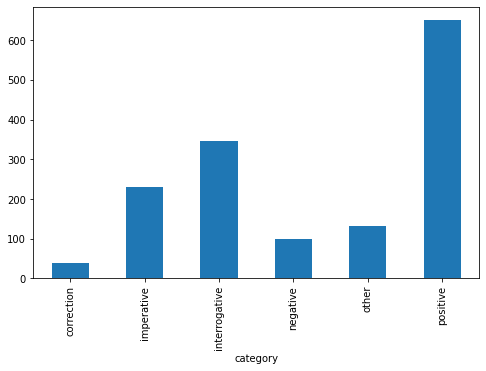

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
df.groupby('category').comment.count().plot.bar(ylim=0)
plt.show()

In [10]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['comment'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 3182 unique tokens.


In [11]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['comment'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1501, 250)


In [12]:
Y = pd.get_dummies(df['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1501, 6)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1350, 250) (1350, 6)
(151, 250) (151, 6)


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
from keras.callbacks import EarlyStopping
# from keras.layers import Dropout

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


/Volumes/MyFiles/Projects/Youtube-Comments-Categorization/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1215 samples, validate on 135 samples
Epoch 1/5
1215/1215 [==============================] - 7s 6ms/step - loss: 1.5996 - accuracy: 0.4337 - val_loss: 1.4426 - val_accuracy: 0.4222
Epoch 2/5
1215/1215 [==============================] - 6s 5ms/step - loss: 1.3913 - accuracy: 0.4675 - val_loss: 1.3307 - val_accuracy: 0.5111
Epoch 3/5
1215/1215 [==============================] - 6s 5ms/step - loss: 1.2496 - accuracy: 0.5498 - val_loss: 1.2225 - val_accuracy: 0.5185
Epoch 4/5
1215/1215 [==============================] - 6s 5ms/step - loss: 1.0834 - accuracy: 0.6123 - val_loss: 1.1136 - val_accuracy: 0.5852
Epoch 5/5
1215/1215 [==============================] - 6s 5ms/step - loss: 0.9113 - accuracy: 0.6626 - val_loss: 1.0152 - val_accuracy: 0.6741


In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

151/151 [==============================] - 0s 2ms/step
Test set
  Loss: 0.925
  Accuracy: 0.669


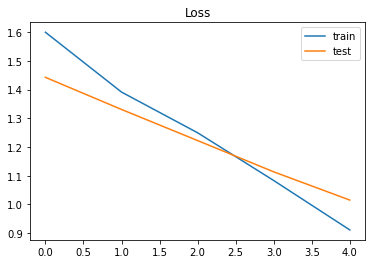

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();